In [24]:
import pandas as pd
import functions as fn
import numpy as np
import seaborn as sns
sns.set_theme(style="white")
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [25]:
sqlGames = 'SELECT * from nhl.dbo.game'
gamesdf = pd.read_sql_query(sqlGames, fn.dbConnection())
gamesdf = gamesdf.rename(columns={'gameid':'gameID'})


gamesdf = gamesdf.drop('gamedate', axis=1)
gamesdf = gamesdf.set_index('gameID')


In [26]:
sqlGoals = '''
SELECT 
DISTINCT gl.gameID,
gl.goalDate as gameDate,
gl.teamID,
count(gl.teamID) as goals,
ga.winner 
from nhl.dbo.goals gl
join nhl.dbo.game ga on gl.gameID = ga.gameID  
GROUP by gl.gameID, gl.teamID, gl.goalDate, ga.winner 
ORDER BY gl.goalDate, gl.gameID, gl.teamID '''

goaldf = pd.read_sql_query(sqlGoals, fn.dbConnection())
#goaldf = pd.read_csv('_SELECT_DISTINCT_gl_gameID_gl_goalDate_as_gameDate_gl_teamID_cou.csv')
goaldf['gamedate'] = pd.to_datetime(goaldf['gamedate'], format='%Y-%m-%d')
goaldf = goaldf.rename(columns={'gameid':'gameID','teamid':'teamID', 'gamedate':'gameDate'})
goaldf = goaldf.set_index('gameID')

In [27]:
windf = goaldf.loc[goaldf['winner'] == goaldf['teamID']]
windf = windf.drop('winner', axis=1)
lossdf = goaldf.loc[goaldf['winner'] != goaldf['teamID']]
lossdf = lossdf.drop({'winner', 'gameDate'}, axis=1)

In [28]:
gamesdf = gamesdf.join(windf)
gamesdf = gamesdf.drop({'winner'}, axis=1)
gamesdf = gamesdf.rename(columns={'teamID': 'winningTeam', 'goals':'winningTeamGoals'})

In [29]:
gamesdf.head()

,visitors,home,so,gameDate,winningTeam,winningTeamGoals
gameID,,,,,,
20231010CHI@PIT,CHI,PIT,X,2023-10-10,CHI,4.0
20231010NSH@TB,NSH,TB,X,2023-10-10,TB,5.0
20231010SEA@LV,SEA,LV,X,NaT,NaN,NaN
20231011CHI@BOS,CHI,BOS,X,2023-10-11,BOS,3.0
20231011COL@LA,COL,LA,X,2023-10-11,COL,5.0


In [30]:
lossdf.head()

,teamID,goals
gameID,,
20231010CHI@PIT,PIT,2
20231010NSH@TB,NSH,3
20231011CHI@BOS,CHI,1
20231011COL@LA,LA,2
20231011EDM@VAN,EDM,1


In [31]:
gamesdf = gamesdf.join(lossdf)
gamesdf = gamesdf.rename(columns={'teamID': 'loosingTeam', 'goals':'loosingTeamGoals'})
gamesdf.sample(10)


,visitors,home,so,gameDate,winningTeam,winningTeamGoals,loosingTeam,loosingTeamGoals
gameID,,,,,,,,
20231028WPG@MON,WPG,MON,SO,2023-10-28,MON,4.0,WPG,3.0
20231105NJ@CHI,NJ,CHI,X,2023-11-05,NJ,4.0,CHI,2.0
20231026STL@CGY,STL,CGY,X,2023-10-26,STL,3.0,NaN,NaN
20231019EDM@PHI,EDM,PHI,X,2023-10-19,PHI,4.0,EDM,1.0
20231109NSH@WPG,NSH,WPG,X,2023-11-09,WPG,6.0,NSH,3.0
20231024BUF@OTT,BUF,OTT,X,2023-10-24,BUF,6.0,OTT,4.0
20231018PIT@DET,PIT,DET,X,2023-10-18,DET,6.0,PIT,3.0
20231028TOR@NSH,TOR,NSH,OT,2023-10-28,NSH,3.0,TOR,2.0
20231021PHI@DAL,PHI,DAL,OT,2023-10-21,DAL,5.0,PHI,4.0


In [32]:
gamesdf = gamesdf.fillna(0)
gamesdf.sample(10)
type(gamesdf)

pandas.core.frame.DataFrame

In [33]:
gamesdf = gamesdf[gamesdf['gameDate'] != 0]
gamesdf.sample(10)
goals = gamesdf[['winningTeamGoals','loosingTeamGoals']]
goals = goals.reset_index(drop=True) 
goals = goals.sort_values(by=['winningTeamGoals','loosingTeamGoals'])
goals = goals.value_counts()
goals = goals.sort_values()
goals = pd.DataFrame(goals)
goals = goals.reset_index(drop=False) 
goals.sample(1)

,winningTeamGoals,loosingTeamGoals,count
26,4.0,1.0,19


[Text(0.5, 0, 'Winning Team Goals'), Text(0, 0.5, 'Loosing Team Goals')]

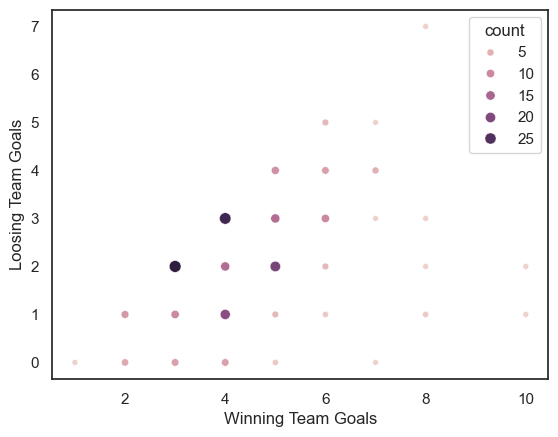

In [34]:
ax = sns.scatterplot(data=goals, x='winningTeamGoals', y='loosingTeamGoals', size='count', hue='count')
ax.set(xlabel='Winning Team Goals', ylabel='Loosing Team Goals')